In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from prophet import Prophet


In [2]:
# Step 0: Loading Data
from ucimlrepo import fetch_ucirepo 

In [ ]:
# loading and merge
dow_jones_index = fetch_ucirepo(id=312)
data = pd.concat([dow_jones_index.data.features, dow_jones_index.data.targets], axis=1)

# transfer date
data['date'] = pd.to_datetime(data['date'])
data.sort_values('date', inplace=True)

# clean 'close' to float
data['close'] = pd.to_numeric(data['close'].astype(str).str.replace('[\$,]', '', regex=True), errors='coerce')
data.fillna(method='ffill', inplace=True)

# creat lag frature
for i in range(1, 6):
    data[f'close_lag_{i}'] = data['close'].shift(i)

# define target parameter
data['future_close'] = data['close'].shift(-5)
data.dropna(inplace=True)
data['price_change_pct'] = ((data['future_close'] - data['close']) / data['close']) * 100

# refine important parameter
df = data[['date', 'close']].rename(columns={'date': 'ds', 'close': 'y'})

C:\Users\msi17\AppData\Local\Temp\ipykernel_21084\834058812.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [ ]:
# standard
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['y']])

# generate sample of ten days to predict
def create_sequences(data, seq_length, pred_length):
    X, y = [], []
    for i in range(len(data)-seq_length-pred_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+pred_length])
    return np.array(X), np.array(y)

seq_length = 10
pred_length = 5  # predict 5 days
X, y = create_sequences(scaled_data, seq_length, pred_length)

# split X and y
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [5]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(pred_length))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20


D:\Anaconda\envs\MLE\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0887 - val_loss: 0.0540
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0453 - val_loss: 0.0510
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0438 - val_loss: 0.0498
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0440 - val_loss: 0.0493
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0422 - val_loss: 0.0490
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0424 - val_loss: 0.0492
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0413 - val_loss: 0.0486
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0428 - val_loss: 0.0487
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0427 - val_loss: 0.0489
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0426 - val_loss: 0.0483
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0410 - val_loss: 0.0479
Epoch 12/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0421 - val_loss: 0.04

In [ ]:
# predict 5 days
last_sequence = scaled_data[-seq_length:].reshape(1, seq_length, 1)
lstm_pred = model.predict(last_sequence)
lstm_pred = scaler.inverse_transform(lstm_pred.reshape(-1, 1))

# calculate
current_price = df['y'].iloc[-1]
pred_prices = lstm_pred.flatten()
price_change_pct = ((pred_prices[-1] - current_price) / current_price) * 100

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


In [ ]:
# train Prophet model
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
prophet_model.fit(df)

# generate 5 days
future = prophet_model.make_future_dataframe(periods=5)
prophet_pred = prophet_model.predict(future)

# outcome of prediction
prophet_last_pred = prophet_pred[['ds', 'yhat']].iloc[-5:]
prophet_price_change_pct = ((prophet_last_pred['yhat'].iloc[-1] - current_price) / current_price) * 100

16:00:57 - cmdstanpy - INFO - Chain [1] start processing
16:00:57 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:

# modify avager logic
# presume lstm_pred 
lstm_last_pred = lstm_pred[-1][0]  # get the last one
prophet_last_pred_value = prophet_last_pred['yhat'].iloc[-1]

# recalcualate final_pct# merger two models
final_pred = (lstm_last_pred * 0.6 + prophet_last_pred_value * 0.4)
final_pct = ((final_pred - current_price) / current_price) * 100

# justify 
price_change_pct = ((pred_prices[-1] - current_price) / current_price) * 100  # get the last one
prophet_price_change_pct = ((prophet_last_pred['yhat'].iloc[-1] - current_price) / current_price) * 10


# risk logic
if final_pct < 0:
    print(f"[预警] 预计下周下跌 {abs(final_pct):.2f}%")
    print(f"LSTM预测跌幅: {abs(price_change_pct):.2f}%")
    print(f"Prophet预测跌幅: {abs(prophet_price_change_pct):.2f}%")
else:
    print(f"预计下周上涨 {final_pct:.2f}%")

[预警] 预计下周下跌 42.87%
LSTM预测跌幅: 37.89%
Prophet预测跌幅: 5.03%


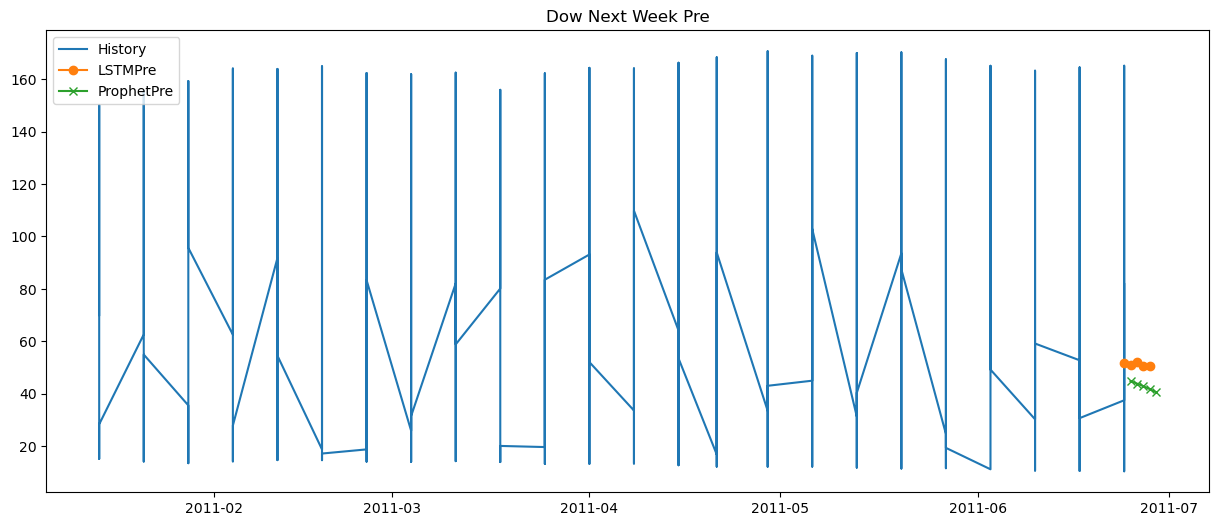

In [ ]:
import matplotlib.pyplot as plt

# print LSTM prediction
plt.figure(figsize=(15, 6))
plt.plot(df['ds'], df['y'], label='History')
plt.plot(pd.date_range(start=df['ds'].iloc[-1], periods=5, freq='D'), lstm_pred, label='LSTMPre', marker='o')
plt.plot(prophet_last_pred['ds'], prophet_last_pred['yhat'], label='ProphetPre', marker='x')
plt.title('Dow Next Week Pre')
plt.legend()
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# RandomForest
# feature and target
features = [col for col in data.columns if 'lag_' in col]
X = data[features]
y = data['price_change_pct']

# X, y order by time
split_idx = int(len(data) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# random forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# estimate model
preds = model.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, preds):.2f}%")

MAE: 120.44%


In [ ]:
# get the lastest data
latest_data = data.iloc[-5:]['close'].tolist()  # the close data of last five days
X_new = pd.DataFrame([latest_data], columns=features)

# predict trend
predicted_pct = model.predict(X_new)[0]

# risk logic
if predicted_pct < 0:
    print(f"Risk：Predict will drop down in the next week {abs(predicted_pct):.2f}%")
else:
    print(f"Predict will raise in the next week {predicted_pct:.2f}%")

预计未来一周上涨 12.24%
